In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import sys
import random
import glob
import pickle
import itertools
import io
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas
import time
from tqdm import tqdm

import sklearn

import tensorflow as tf
import tf_data


In [4]:
import tensorflow as tf
import json, os
import numpy as np

# Tested with TensorFlow 2.1.0
print('version={}, CUDA={}, GPU={}, TPU={}'.format(
    tf.__version__, tf.test.is_built_with_cuda(),
    # GPU attached?
    len(tf.config.list_physical_devices('GPU')) > 0,
    # TPU accessible? (only works on Colab)
    'COLAB_TPU_ADDR' in os.environ))

if len(tf.config.list_physical_devices('GPU')) > 0:
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
    strategy = tf.distribute.OneDeviceStrategy("gpu:0")

version=2.3.0, CUDA=True, GPU=True, TPU=False


# Dataset building

In [5]:
data_path = {#"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/training/calo_matched/*.proto",
             #"gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/calo_matched/*.proto",
             "ele_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/training/no_calo_matched/*.proto",
             #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/no_calo_matched/*.proto"
            }

In [6]:
features = [ "en_cluster","et_cluster", 
            "cluster_ieta","cluster_iphi","cluster_iz",
            "cluster_deta", "cluster_dphi",
            "cl_swissCross", "cl_nxtals", "cl_etaWidth","cl_phiWidth"]

In [7]:
_load_n_items = 10
_batch_size = 6
_nepochs = 100
_ntrain = 10000
_nval = 1000

In [8]:
# Load a balanced dataset from the list of paths given to the function. Selected only the requestes features from clusters and prepare batches
total_ds = tf_data.load_balanced_dataset_batch(data_path, features, _batch_size)
# the indexes for energy and et are from the features list we requestes
total_ds = tf_data.delta_energy_seed(total_ds, en_index=0, et_index=1)
total_ds = tf_data.training_format(total_ds) 

In [9]:
X,y = tf_data.get(total_ds)

In [11]:
y_class, y_metadata = y

In [13]:
y_class

<tf.Tensor: shape=(6, 7, 1), dtype=int64, numpy=
array([[[1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]],

       [[1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]],

       [[1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]],

       [[1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]],

       [[1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]],

       [[1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]]])>

In [10]:
cl_X,cl_hits, is_seed,n_cl = X

# Graph building layer

In [14]:
from model import *
from plotting import * 

In [108]:
graph = GraphBuilding(output_dim_nodes=32)

In [109]:
cl_x, coord, adj, mask = graph(X[0],X[1])

In [110]:
mask

<tf.Tensor: shape=(6, 9), dtype=float32, numpy=
array([[1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0.]], dtype=float32)>

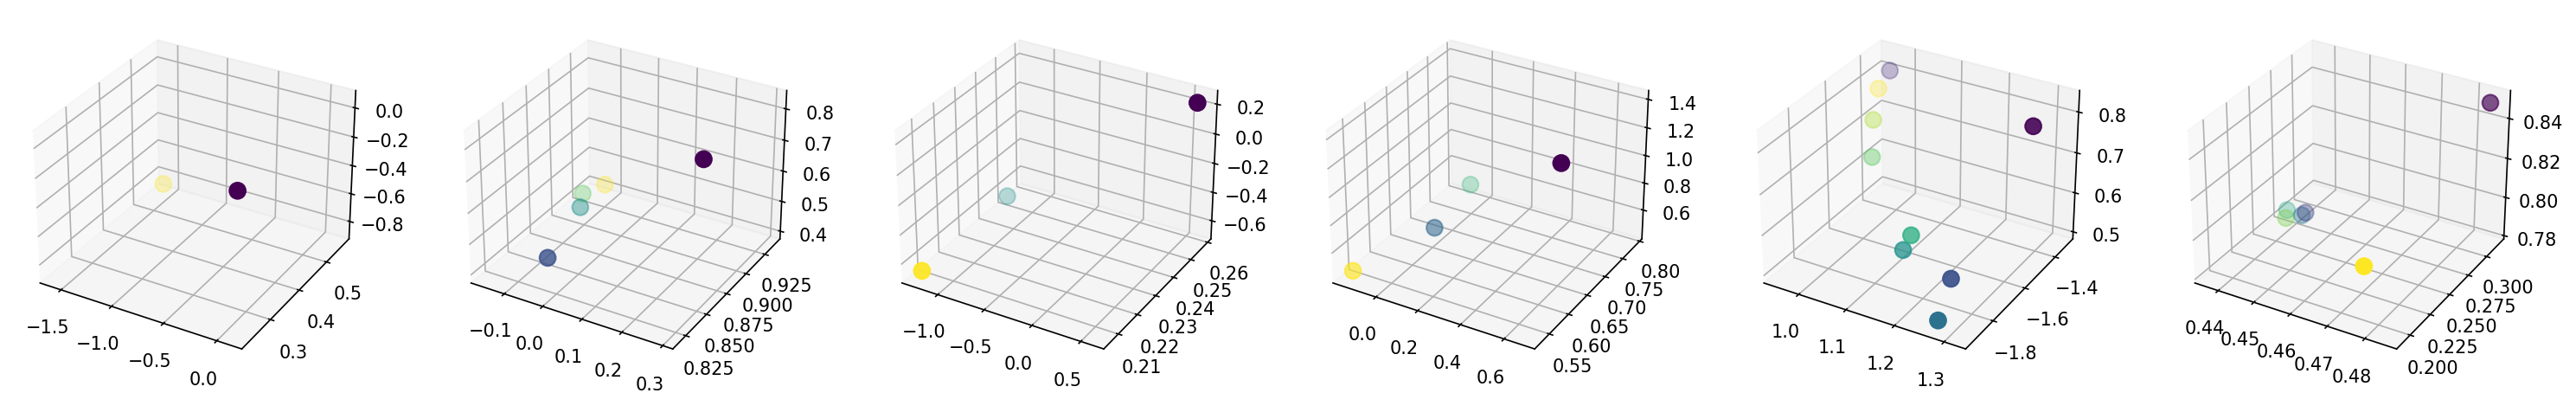

In [111]:
plot3D(coord, mask)

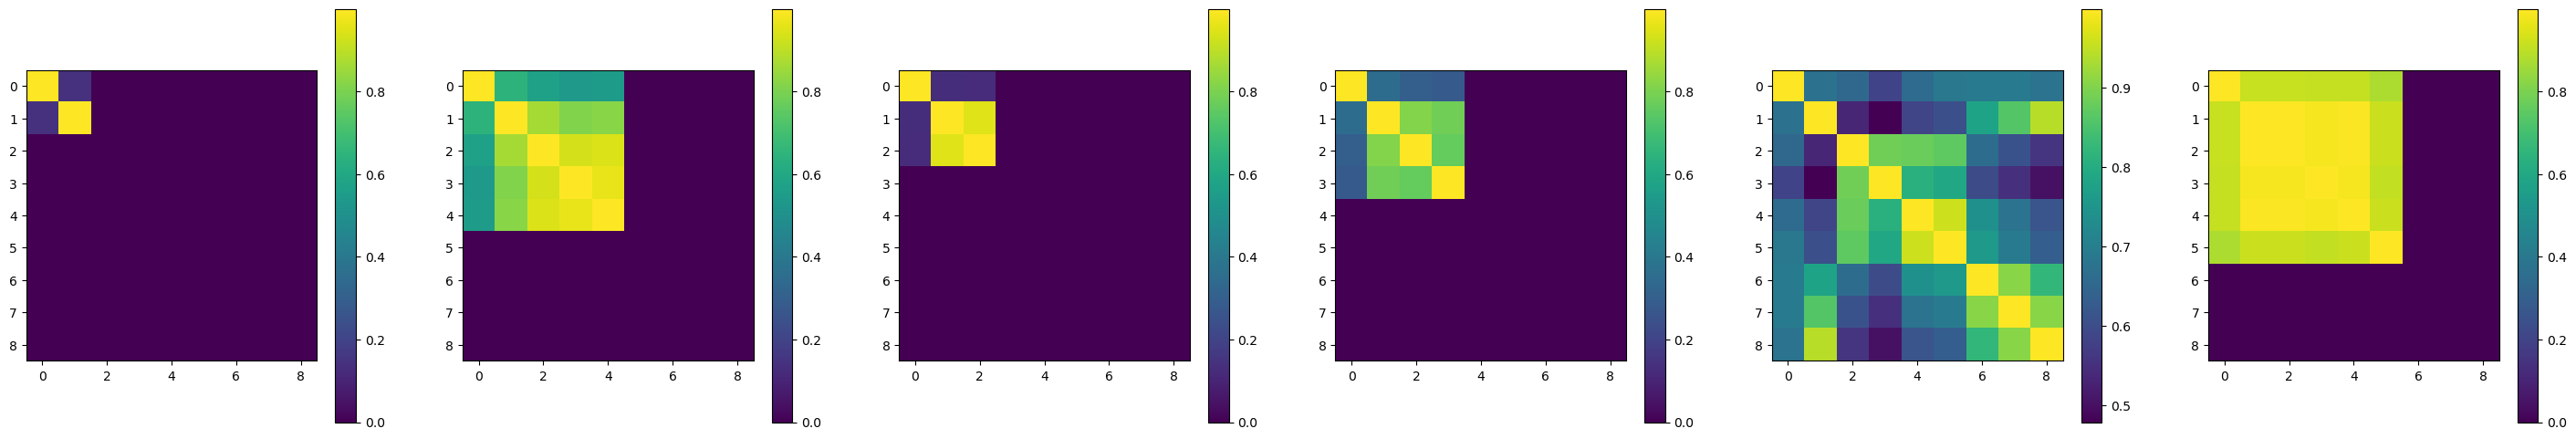

In [112]:
plotM(*adj)

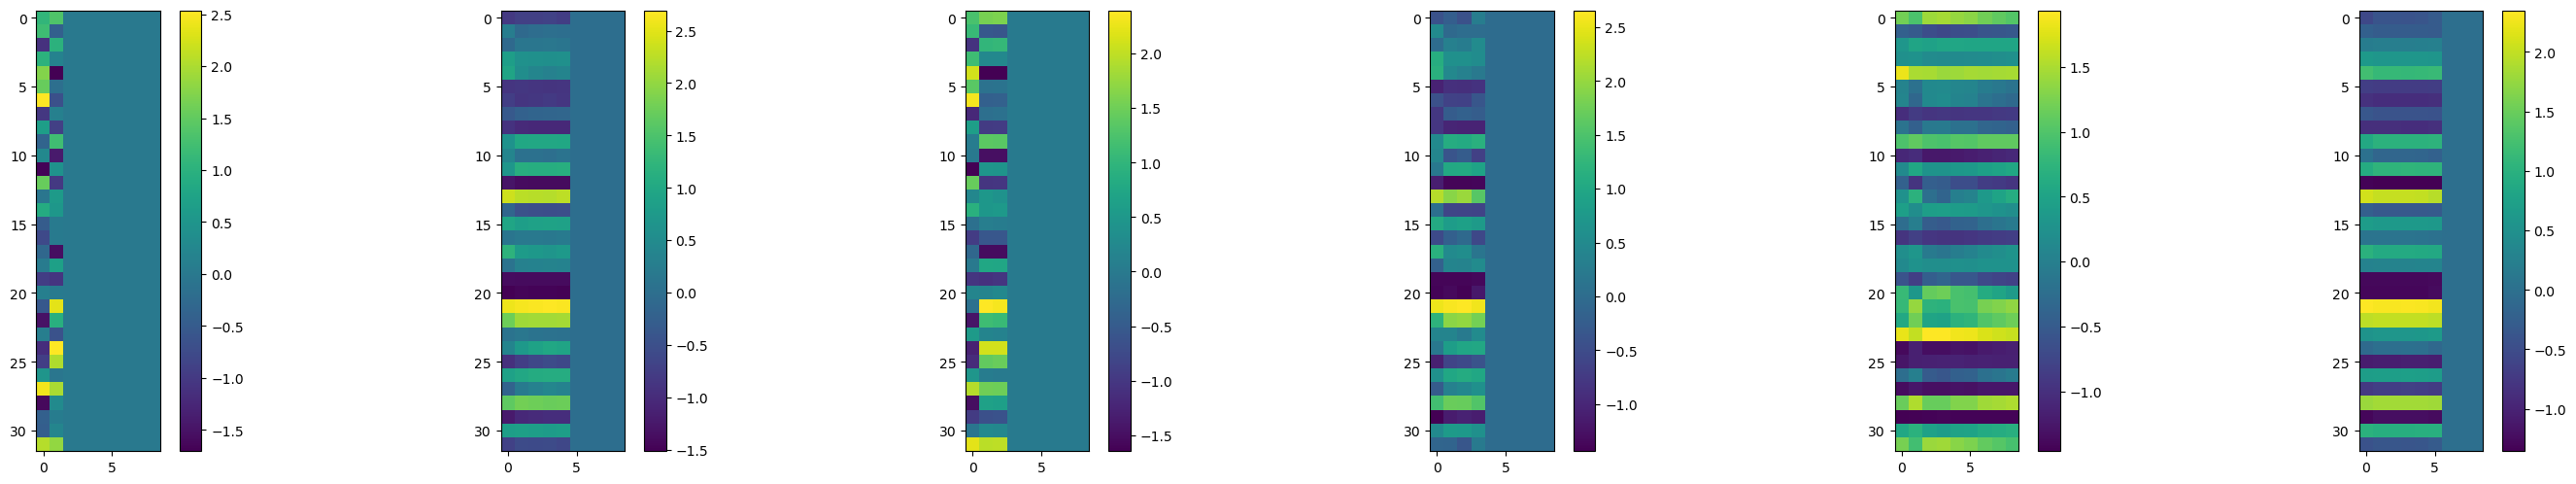

In [113]:
plotM(*cl_x)

# Complete model

In [109]:
help(DeepClusterGN)

Help on class DeepClusterGN in module model:

class DeepClusterGN(tensorflow.python.keras.engine.training.Model)
 |  DeepClusterGN(*args, **kwargs)
 |  
 |  Model parameters:
 |  - activation
 |  - output_dim_nodes: latent space dimension for clusters node built from rechits and cluster features
 |  - output_dim_rechits:  latent space dimension for the rechits per-cluster feature vector
 |  - output_dim_gconv: output of the graph convolution (default==output_dim_nodes)
 |  - output_dim_clclass: output of the self-attention layer for cluster classification (default==output_dim_gconv)
 |  - coord_dim:  coordinated space dimension
 |  - nconv_rechits: number of convolutions for the rechits GCN
 |  - nconv: number of convolutions for the global model
 |  - layers_input:  list representing the DNN applied on the [rechit+cluster] concatened features to build the clusters latent space
 |  - layers_coord:  list representing the DNN applied on the clusters latent space to extract the coordinate

In [114]:
# output_dim_nodes == latent spoace dimension for the clusters
dcgn = DeepClusterGN(nconv=3, output_dim_nodes=64, layers_input=[64,64,64], layers_coord=[64,64,64,64])

In [54]:
dense_clclass, mask_cls, (cl_X, coord, adj ,out_gcn, out_SA) = model(X)

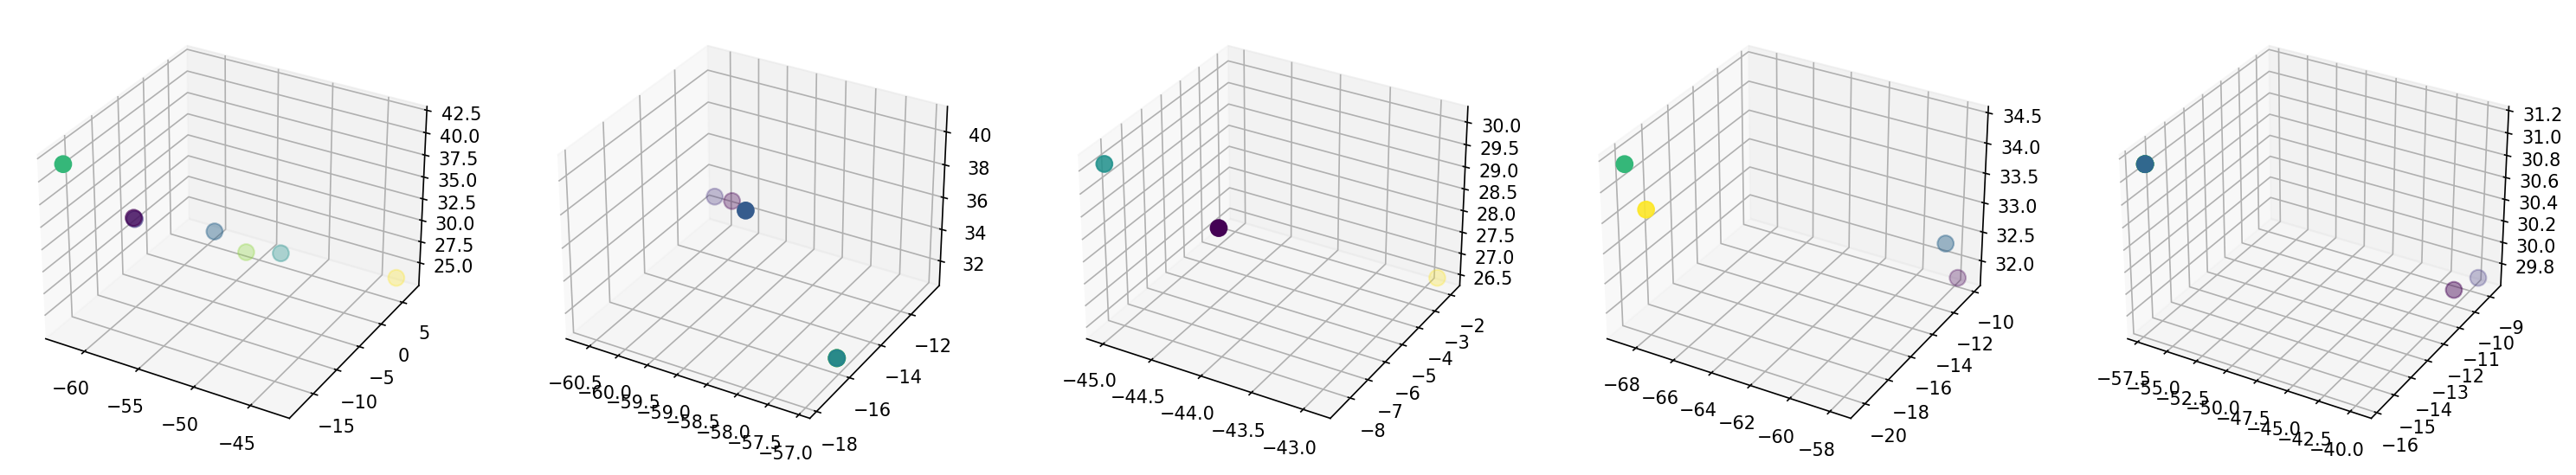

In [56]:
plot3D(coord[1:6], mask_cls)

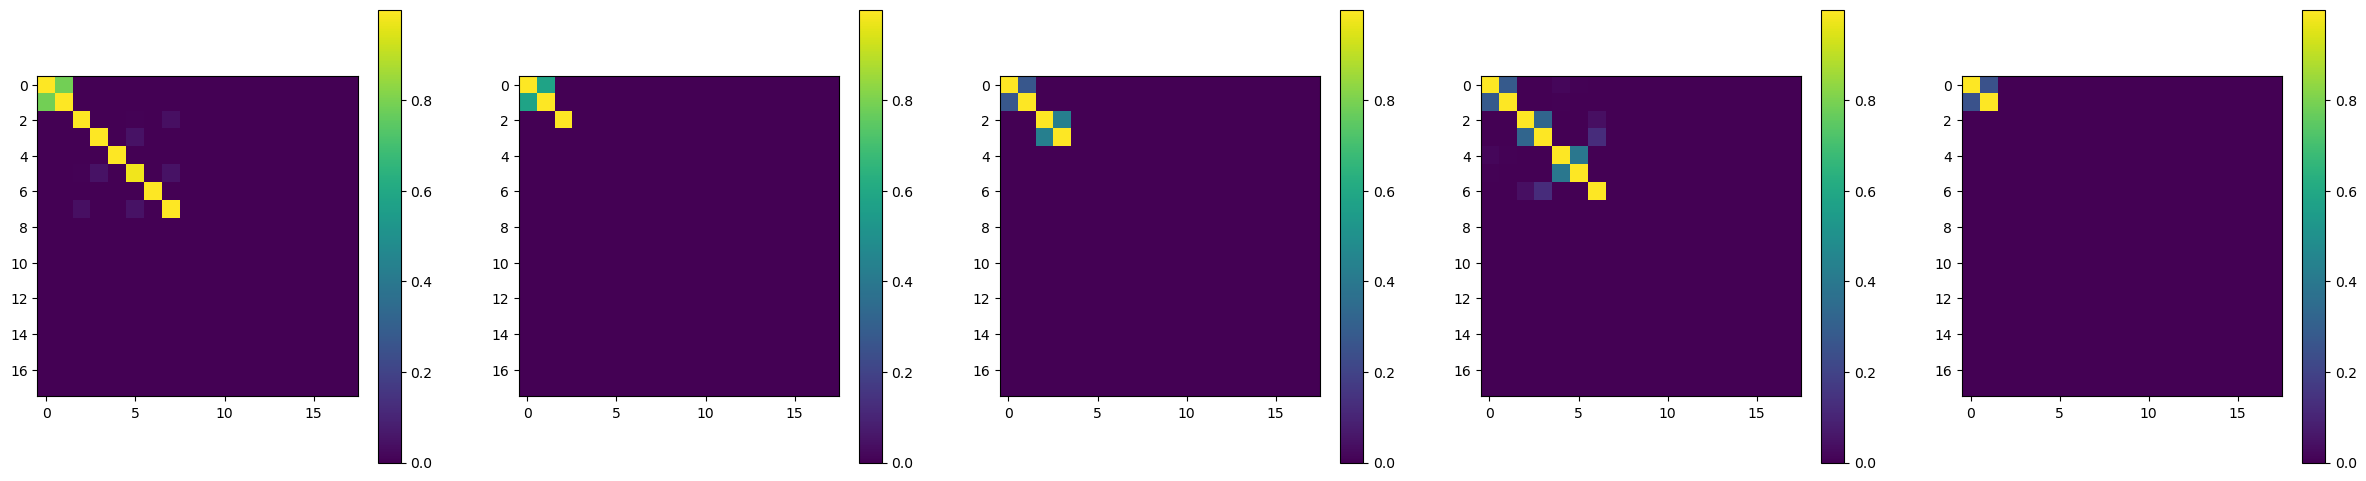

In [57]:
plotM(*adj[1:6])

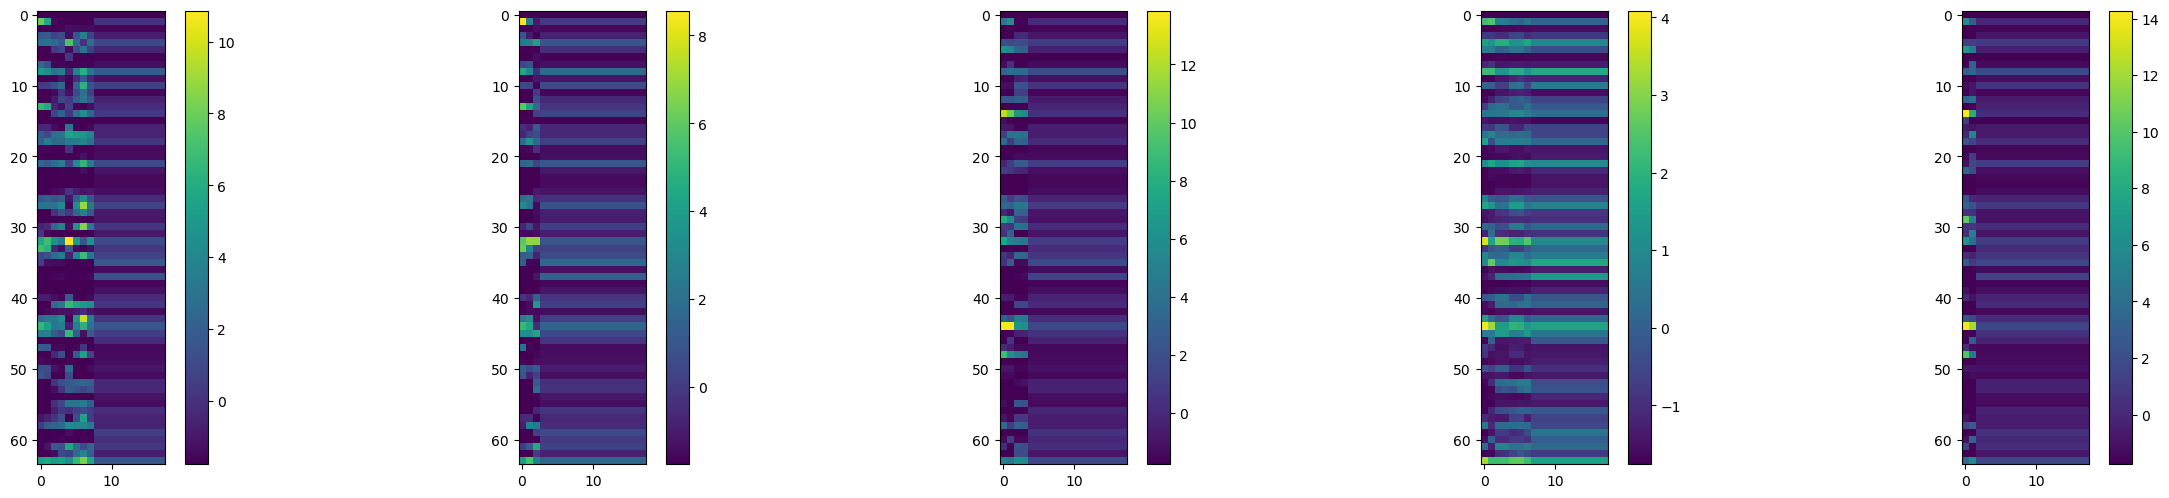

In [58]:
plotM(*cl_X[1:6])

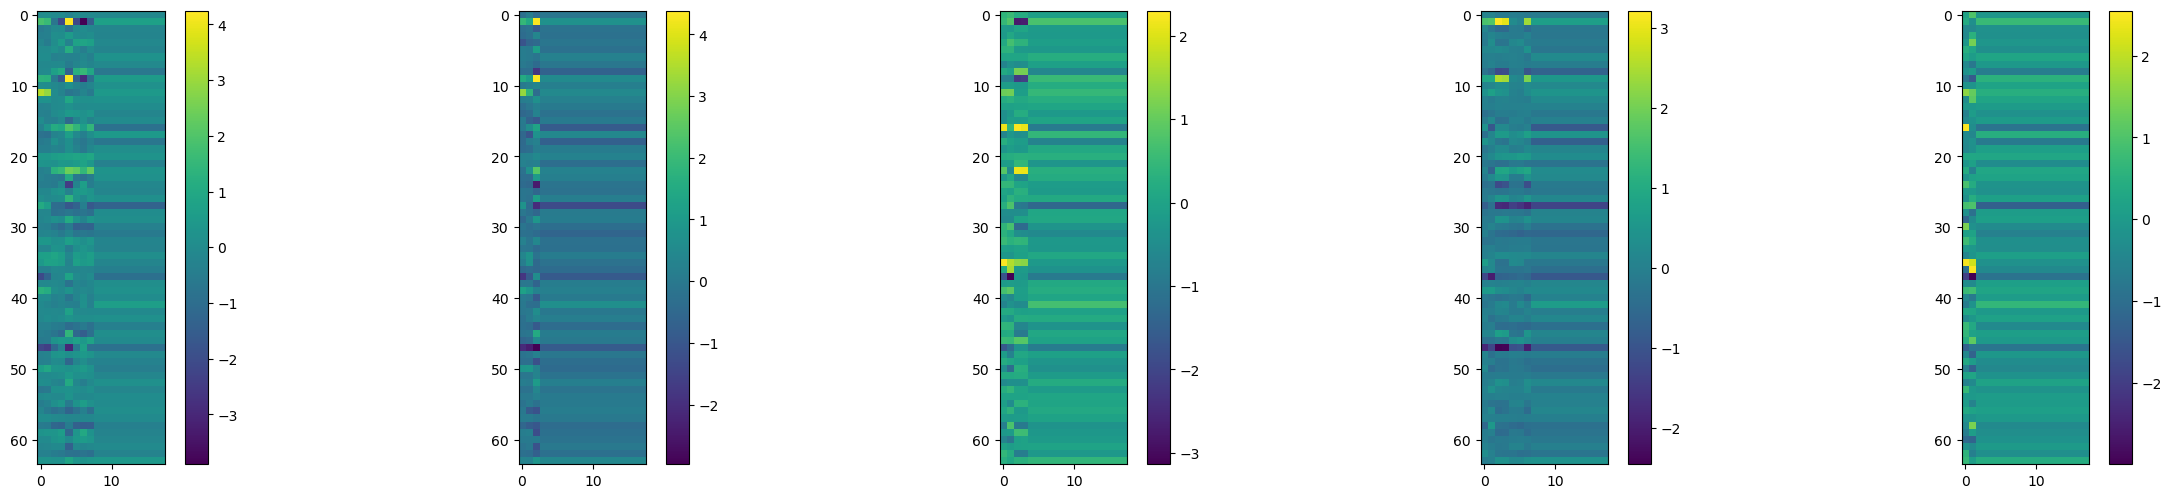

In [59]:
plotM(*out_gcn[1:6])

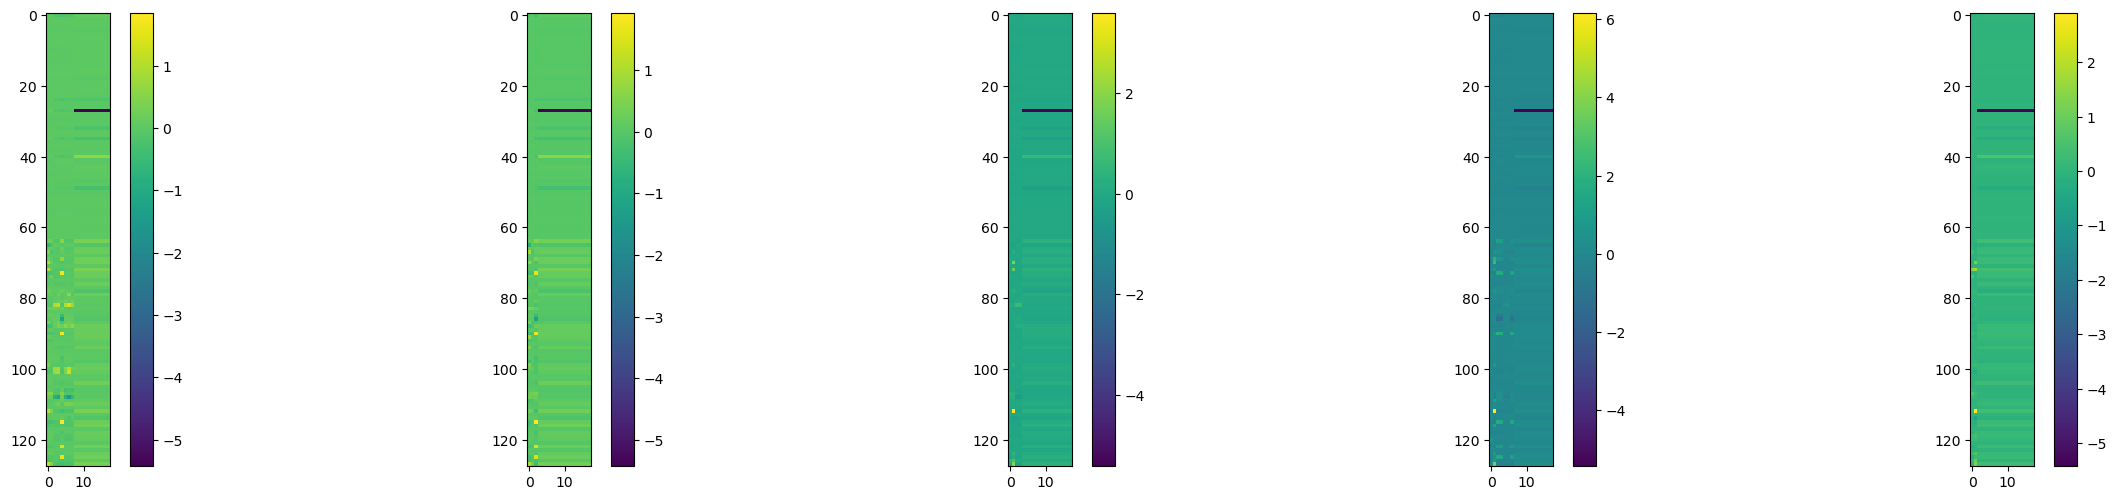

In [60]:
plotM(*out_SA[1:6])

# Loss function

In [122]:
y_pred = dcgn(X)
y_true = y 

In [147]:
dense_clclass, mask_cls, _  = y_pred
y_class, y_metadata = y_true
cl_X, cl_hits, is_seed,n_cl = X
cl_ets = cl_X[:,:,1]
cl_ets = cl_X[:,:,1] / tf.reduce_sum(cl_X[:,:,1], axis=-1)[:,tf.newaxis]
class_loss = tf.keras.losses.binary_crossentropy(y_class, dense_clclass, from_logits=True) * mask_cls
weighted_loss = class_loss * cl_ets
reduced_loss = tf.reduce_mean(tf.reduce_sum(weighted_loss, axis=-1))

In [148]:
reduced_loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.7460188>

In [139]:
cl_ets

<tf.Tensor: shape=(6, 9), dtype=float32, numpy=
array([[0.99097526, 0.00902472, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.9442082 , 0.01824968, 0.01601619, 0.0136416 , 0.00788432,
        0.        , 0.        , 0.        , 0.        ],
       [0.9814058 , 0.01222331, 0.0063709 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.96620196, 0.01527102, 0.01035268, 0.00817437, 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.63366574, 0.07908539, 0.0708131 , 0.04544425, 0.04703614,
        0.03674164, 0.03220187, 0.02862877, 0.02638305],
       [0.87168705, 0.03600075, 0.02746342, 0.02085922, 0.02198319,
        0.02200637, 0.        , 0.        , 0.        ]], dtype=float32)>

In [142]:
class_loss * cl_ets

<tf.Tensor: shape=(6, 9), dtype=float32, numpy=
array([[0.8230275 , 0.00819976, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.5212897 , 0.01860948, 0.01728104, 0.01519303, 0.00852453,
        0.        , 0.        , 0.        , 0.        ],
       [0.6676767 , 0.01231157, 0.00635121, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.65824145, 0.0160317 , 0.01159984, 0.00973836, 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.7663845 , 0.02708488, 0.02952536, 0.01848048, 0.01748035,
        0.01270849, 0.01066921, 0.00946161, 0.00884692],
       [0.6992406 , 0.02306593, 0.01761571, 0.0134402 , 0.01414568,
        0.01388686, 0.        , 0.        , 0.        ]], dtype=float32)>

In [ ]:
reduced_loss = tf.reduce_mean(tf.reduce_sum(class_loss, axis=-

# Test training

In [40]:
from model import *
from plotting import * 

In [41]:
models_path = "/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v1/"

#rain_steps_per_epoch = 
#eval_steps_per_epoch = 3e5 // batch_size
from collections import namedtuple
# Args = namedtuple('args', [ 'models_path', 'load','nepochs','ntrain','nval','nfeatures',
#                             'n_seed_features','batch_size','lr_decay','lr',
#                             'hidden_dim_input','hidden_dim_coord', 'hidden_dim_id',
#                             'n_layers_input', 'n_layers_id', 'n_layers_coord',
#                            'distance_dim','num_conv','dropout','convlayer',
#                            'nclass_labels', 'opt'])
Args = namedtuple('args', [ 'models_path', 'load','nepochs','ntrain','nval',
                           'lr_decay','lr', 'batch_size','opt', 'debug'])


args = Args( 
models_path = models_path,
load = False,
nepochs = 100,
ntrain = 400000,
nval = 50000,
# nfeatures = 13,
# n_seed_features = 12,
lr_decay = 0.4,
lr = 1e-4,
batch_size = 64,
# n_layers_input = 3,
# n_layers_id = 3,
# n_layers_coord = 3,
# hidden_dim_input = 200,
# hidden_dim_coord = 200,
# hidden_dim_id = 200,
# distance_dim = 200,
# num_conv = 2,
# dropout = 0.2,
# convlayer = 'sgconv',
# nclass_labels=2,
opt='nadam',
debug = False
        )

### Dataset loading

In [16]:
def get_unique_run():
    previous_runs = os.listdir(args.models_path)
    if len(previous_runs) == 0:
        run_number = 1
    else:
        run_number = max([int(s.split('run_')[1]) for s in previous_runs]) + 1
    return run_number


if not os.path.isdir(args.models_path):
    os.makedirs(args.models_path)

name =  'run_{:02}'.format(get_unique_run())

outdir = args.models_path + name

if os.path.isdir(outdir):
    print("Output directory exists: {}".format(outdir), file=sys.stderr)
else:
    os.makedirs(outdir)

print(outdir)

/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v1/run_20


In [42]:
data_path_train = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/training/calo_matched/*.proto",
                  "gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/calo_matched/*.proto",
                  "ele_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/training/no_calo_matched/*.proto",
                  #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/no_calo_matched/*.proto"
                  }
data_path_test = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/testing/calo_matched/*.proto",
                  "gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/testing/calo_matched/*.proto",
                  "ele_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/testing/no_calo_matched/*.proto",
                  #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/testing/no_calo_matched/*.proto"
                  }

In [43]:
features = [ "en_cluster","et_cluster", 
            "cluster_ieta","cluster_iphi","cluster_iz",
            "cluster_deta", "cluster_dphi",
            "cl_r9", "cl_sigmaIetaIeta", "cl_sigmaIetaIphi",
            "cl_sigmaIphiIphi","cl_swissCross",
            "cl_nxtals", "cl_etaWidth","cl_phiWidth"]

In [44]:
# Load a balanced dataset from the list of paths given to the function. Selected only the requestes features from clusters and prepare batches
train_ds = tf_data.load_balanced_dataset_batch(data_path_train, features, args.batch_size, weights={"ele_match":0.4,"gamma_match":0.4, "ele_nomatch":0.2})
# the indexes for energy and et are from the features list we requestes
train_ds = tf_data.delta_energy_seed(train_ds, en_index=0, et_index=1)
train_ds = tf_data.training_format(train_ds).shuffle(buffer_size=200)


test_ds = tf_data.load_balanced_dataset_batch(data_path_test, features, args.batch_size,weights={"ele_match":0.4,"gamma_match":0.4, "ele_nomatch":0.2})
# the indexes for energy and et are from the features list we requestes
test_ds = tf_data.delta_energy_seed(test_ds, en_index=0, et_index=1)
test_ds = tf_data.training_format(test_ds).shuffle(buffer_size=200)


# Create training and validation
ds_train = train_ds.prefetch(100).take(args.ntrain).repeat(args.nepochs)
ds_test  = test_ds.prefetch(100).take(args.nval).repeat(args.nepochs)

In [45]:
if args.lr_decay > 0:
        #lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        #    args.lr,
        #    decay_steps=int(args.ntrain//args.batch_size),
        #    decay_rate=args.lr_decay
        #)
        lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
            args.lr,
            decay_steps=int(args.ntrain//args.batch_size),
            decay_rate=args.lr_decay,
            staircase=True
        )
else:
    lr_schedule = args.lr


In [46]:
help(DeepClusterGN)

Help on class DeepClusterGN in module model:

class DeepClusterGN(tensorflow.python.keras.engine.training.Model)
 |  DeepClusterGN(*args, **kwargs)
 |  
 |  Model parameters:
 |  - activation
 |  - output_dim_nodes: latent space dimension for clusters node built from rechits and cluster features
 |  - output_dim_rechits:  latent space dimension for the rechits per-cluster feature vector
 |  - output_dim_gconv: output of the graph convolution (default==output_dim_nodes)
 |  - output_dim_clclass: output of the self-attention layer for cluster classification (default==output_dim_gconv)
 |  - coord_dim:  coordinated space dimension
 |  - nconv_rechits: number of convolutions for the rechits GCN
 |  - nconv: number of convolutions for the global model
 |  - layers_input:  list representing the DNN applied on the [rechit+cluster] concatened features to build the clusters latent space
 |  - layers_coord:  list representing the DNN applied on the clusters latent space to extract the coordinate

In [47]:
with strategy.scope():
    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    # Construction of the model
    model = DeepClusterGN(nconv=3, output_dim_rechits=32, output_dim_nodes=64, layers_input=[64,64], layers_coord=[64,64],
                          output_dim_gconv=64,layers_clclass=[128,128,64], dropout=0.15, activation=tf.keras.activations.selu)
    
    model.compile(optimizer=args.opt)
#         metrics=[Precision(),Recall(), energy_resolution_insc,energy_resolution_outsc,
#                      energy_resolution_insc_log,energy_resolution_outsc_log,])
    model.set_metrics()

    for X, y in ds_train:
        ypred = model(X)
        #l = custom_loss(y, ypred)
        break

In [48]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances


No known TensorBoard instances running.


In [49]:
callbacks = []
tb = tf.keras.callbacks.TensorBoard(
    log_dir=outdir, histogram_freq=2, 
    write_graph=False, 
    write_images=True,
    update_freq='epoch',
    profile_batch=0,
)
tb.set_model(model)
callbacks += [tb]

terminate_cb = tf.keras.callbacks.TerminateOnNaN()
callbacks += [terminate_cb]

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=outdir + "/weights.{epoch:02d}-{val_loss:.6f}.hdf5",
    save_weights_only=True,
    verbose=1
)
cp_callback.set_model(model)
callbacks += [cp_callback]



In [50]:
model.summary()

Model: "deep_cluster_gn_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
graph_building_3 (GraphBuild multiple                  16423     
_________________________________________________________________
gh_conv_i_7 (GHConvI)        multiple                  8256      
_________________________________________________________________
concatenate_7 (Concatenate)  multiple                  0         
_________________________________________________________________
self_attention_3 (SelfAttent multiple                  20608     
_________________________________________________________________
sequential_11 (Sequential)   (64, 18, 1)               33153     
_________________________________________________________________
layer_normalization_14 (Laye multiple                  128       
_________________________________________________________________
layer_normalization_15 (Laye multiple            

In [51]:
if args.load:
    #ensure model input size is known
    for X, y in ds_train:
        model(X)
        break

    model.load_weights(args.load)
    
if args.nepochs > 0:
    ret = model.fit(ds_train,
        validation_data=ds_test, 
        epochs=args.nepochs,
        steps_per_epoch=args.ntrain//args.batch_size, 
        validation_steps=args.nval//args.batch_size,
        verbose=True,
        callbacks = callbacks
    )

Epoch 1/100
6250/6250 [==============================] - ETA: 0s - loss: 1.8332 - loss_simple: 1.7297 - loss_etweighted: 0.1414
Epoch 00001: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v1/run_20/weights.01-1.677095.hdf5
6250/6250 [==============================] - 150s 24ms/step - loss: 1.8332 - loss_simple: 1.7297 - loss_etweighted: 0.1414 - val_loss: 1.6771 - val_loss_simple: 1.5926 - val_loss_etweighted: 0.0845
Epoch 2/100
6248/6250 [============================>.] - ETA: 0s - loss: 1.6466 - loss_simple: 1.5640 - loss_etweighted: 0.0833
Epoch 00002: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v1/run_20/weights.02-1.616033.hdf5
6250/6250 [==============================] - 148s 24ms/step - loss: 1.6468 - loss_simple: 1.5641 - loss_etweighted: 0.0833 - val_loss: 1.6160 - val_loss_simple: 1.5349 - val_loss_etweighted: 0.0811
Epoch 3/100
6250/6250 [===========================

6249/6250 [============================>.] - ETA: 0s - loss: 2.6050e-06 - loss_simple: 2.1691e-06 - loss_etweighted: 1.1520e-06
Epoch 00018: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v1/run_20/weights.18-27.742565.hdf5
6250/6250 [==============================] - 153s 24ms/step - loss: 2.6046e-06 - loss_simple: 2.1687e-06 - loss_etweighted: 1.1517e-06 - val_loss: 27.7426 - val_loss_simple: 23.4057 - val_loss_etweighted: 4.3369
Epoch 19/100
6249/6250 [============================>.] - ETA: 0s - loss: 7.1489e-04 - loss_simple: 5.4707e-04 - loss_etweighted: 3.5727e-04
Epoch 00019: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v1/run_20/weights.19-30.775505.hdf5
6250/6250 [==============================] - 153s 24ms/step - loss: 7.1478e-04 - loss_simple: 5.4699e-04 - loss_etweighted: 3.5721e-04 - val_loss: 30.7755 - val_loss_simple: 25.6617 - val_loss_etweighted: 5.1138
Epoch 2

Epoch 35/100
6249/6250 [============================>.] - ETA: 0s - loss: 0.9757 - loss_simple: 0.9308 - loss_etweighted: 0.0442
Epoch 00035: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v1/run_20/weights.35-1.001020.hdf5
6250/6250 [==============================] - 151s 24ms/step - loss: 0.9757 - loss_simple: 0.9308 - loss_etweighted: 0.0442 - val_loss: 1.0010 - val_loss_simple: 0.9567 - val_loss_etweighted: 0.0443
Epoch 36/100
6249/6250 [============================>.] - ETA: 0s - loss: 0.9833 - loss_simple: 0.9391 - loss_etweighted: 0.0441
Epoch 00036: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v1/run_20/weights.36-0.951604.hdf5
6250/6250 [==============================] - 150s 24ms/step - loss: 0.9834 - loss_simple: 0.9392 - loss_etweighted: 0.0441 - val_loss: 0.9516 - val_loss_simple: 0.9089 - val_loss_etweighted: 0.0427
Epoch 37/100
6250/6250 [========================

Epoch 52/100
6248/6250 [============================>.] - ETA: 0s - loss: 2.0796e-06 - loss_simple: 1.9419e-06 - loss_etweighted: 8.6227e-08
Epoch 00052: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v1/run_20/weights.52-66.691177.hdf5
6250/6250 [==============================] - 165s 26ms/step - loss: 2.0789e-06 - loss_simple: 1.9413e-06 - loss_etweighted: 8.6252e-08 - val_loss: 66.6912 - val_loss_simple: 56.0046 - val_loss_etweighted: 10.6867
Epoch 53/100
6250/6250 [==============================] - ETA: 0s - loss: 3.1129e-04 - loss_simple: 2.4441e-04 - loss_etweighted: 1.8822e-05
Epoch 00053: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v1/run_20/weights.53-63.521648.hdf5
6250/6250 [==============================] - 163s 26ms/step - loss: 3.1129e-04 - loss_simple: 2.4441e-04 - loss_etweighted: 1.8830e-05 - val_loss: 63.5216 - val_loss_simple: 53.5196 - val_loss_etweighted: 

Epoch 69/100
6248/6250 [============================>.] - ETA: 0s - loss: 0.9399 - loss_simple: 0.8973 - loss_etweighted: 0.0427
Epoch 00069: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v1/run_20/weights.69-1.009713.hdf5
6250/6250 [==============================] - 153s 25ms/step - loss: 0.9400 - loss_simple: 0.8974 - loss_etweighted: 0.0427 - val_loss: 1.0097 - val_loss_simple: 0.9621 - val_loss_etweighted: 0.0477
Epoch 70/100
6248/6250 [============================>.] - ETA: 0s - loss: 0.9440 - loss_simple: 0.9014 - loss_etweighted: 0.0427
Epoch 00070: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v1/run_20/weights.70-0.905816.hdf5
6250/6250 [==============================] - 151s 24ms/step - loss: 0.9441 - loss_simple: 0.9014 - loss_etweighted: 0.0427 - val_loss: 0.9058 - val_loss_simple: 0.8665 - val_loss_etweighted: 0.0393
Epoch 71/100
6249/6250 [========================

Epoch 86/100
6248/6250 [============================>.] - ETA: 0s - loss: 0.9468 - loss_simple: 0.8939 - loss_etweighted: 0.0241
Epoch 00086: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v1/run_20/weights.86-1.196002.hdf5
6250/6250 [==============================] - 153s 25ms/step - loss: 0.9470 - loss_simple: 0.8941 - loss_etweighted: 0.0242 - val_loss: 1.1960 - val_loss_simple: 1.1312 - val_loss_etweighted: 0.0648
Epoch 87/100
6248/6250 [============================>.] - ETA: 0s - loss: 1.1012 - loss_simple: 1.0423 - loss_etweighted: 0.0618
Epoch 00087: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v1/run_20/weights.87-1.030679.hdf5
6250/6250 [==============================] - 146s 23ms/step - loss: 1.1013 - loss_simple: 1.0424 - loss_etweighted: 0.0618 - val_loss: 1.0307 - val_loss_simple: 0.9789 - val_loss_etweighted: 0.0518
Epoch 88/100
6250/6250 [========================

(0.6, 2.0)

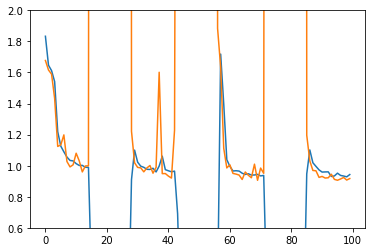

In [52]:
plt.plot(ret.history["loss"])
plt.plot(ret.history["val_loss"])
plt.ylim(0.6,2)

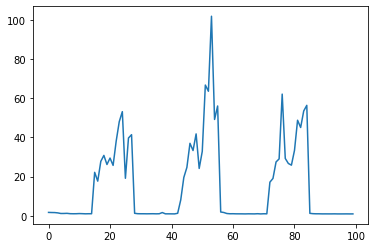

In [53]:
plt.plot(ret.history["val_loss"])

In [79]:
with open(outdir + "/args.txt",'w') as config:
    config.write(str(args))
    
model.save(outdir+"/model")
    

In [ ]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [ ]:
#OLd model
